In [25]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import pandas_datareader.data as web
import numpy as np
import pandas as pd

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [26]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=15)
        fig.subplots_adjust(top=.9)

In [34]:
# chk: https://fred.stlouisfed.org/series/IPGMFN
# IPGMFN monthly data
industrial_production = web.DataReader('IPGMFN', 'fred', '2000', '2022-12-31').squeeze().dropna()
# NASDAQCOM daily data
# chk: https://www.nasdaq.com/market-activity/index/comp
nasdaq = web.DataReader('NASDAQCOM', 'fred', '2000', '2022-12-31').squeeze().dropna()

In [35]:
pd.concat([industrial_production.head(), nasdaq.head()], axis=1)

,IPGMFN,NASDAQCOM
DATE,,
2000-01-01,90.0161,NaN
2000-01-03,NaN,4131.15
2000-01-04,NaN,3901.69
2000-01-05,NaN,3877.54
2000-01-06,NaN,3727.13
2000-01-07,NaN,3882.62
2000-02-01,91.8406,NaN
2000-03-01,94.3500,NaN
2000-04-01,93.2407,NaN


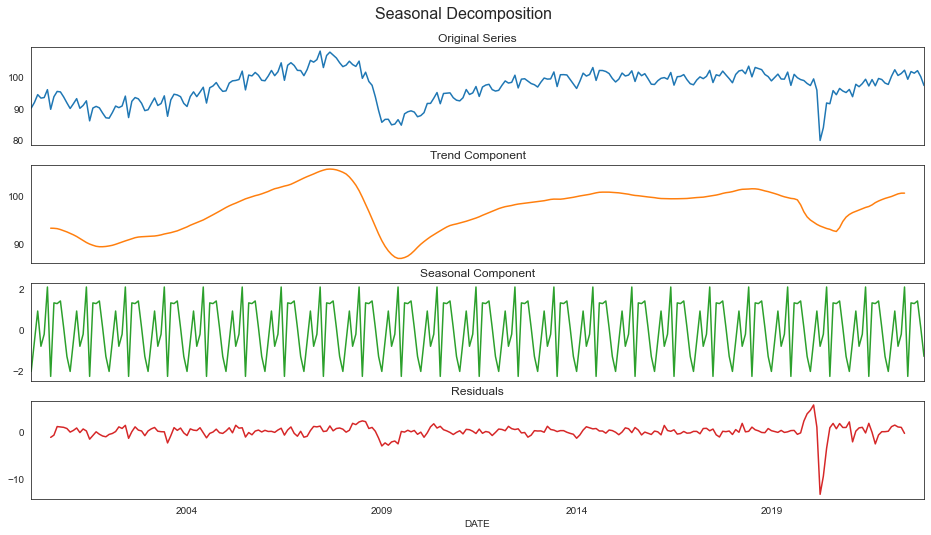

In [43]:
# Seasonal decomposition using MA by Trend, Seasonality, Residual
components = tsa.seasonal_decompose(industrial_production, model='additive')
ts = (industrial_production.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(16, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=16)
    plt.subplots_adjust(top=.91);

In [41]:
pd.concat([ts.head(), ts.tail()])

,Original,Trend,Seasonality,Residual
DATE,,,,
2000-01-01,90.0161,NaN,-2.033370,NaN
2000-02-01,91.8406,NaN,-0.558407,NaN
2000-03-01,94.3500,NaN,0.925992,NaN
2000-04-01,93.2407,NaN,-0.801315,NaN
2000-05-01,93.4120,NaN,-0.208547,NaN
2022-08-01,101.7727,NaN,1.325636,NaN
2022-09-01,101.2498,NaN,1.290896,NaN
2022-10-01,102.0608,NaN,1.419603,NaN
2022-11-01,100.1379,NaN,0.110146,NaN


In [45]:
# just for chk purpose. and it should be (False, False)
(nasdaq == 0).any(), (industrial_production==0).any()

(False, False)

In [52]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

In [56]:
nasdaq_log_diff = nasdaq_log.diff().dropna()

# seasonal differencing => yoy(year-over-year) instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

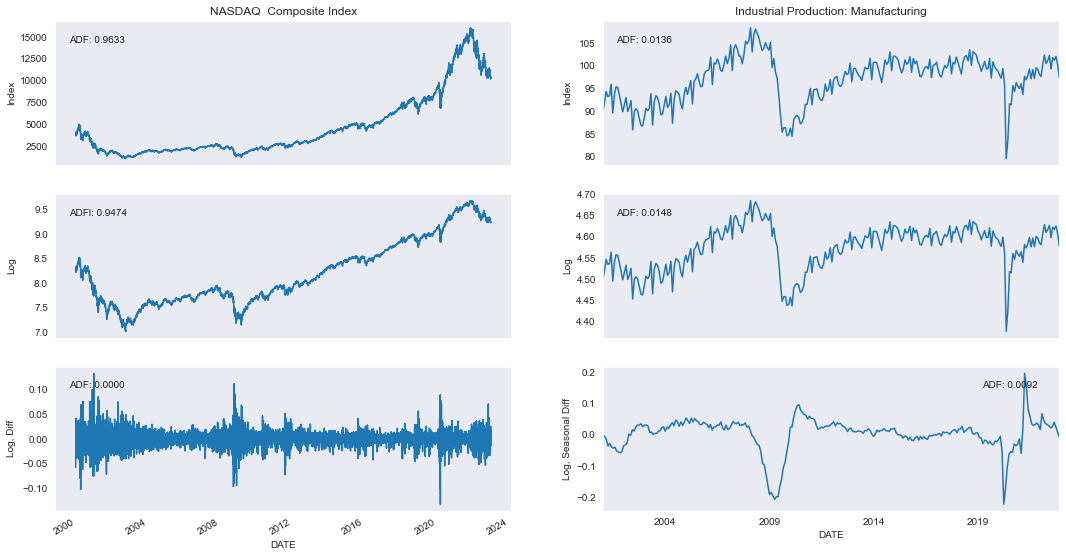

In [33]:
with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))

    # nasdaq
    nasdaq.plot(ax=axes[0][0],title='NASDAQ  Composite Index')
    # ADF(Augmented Dickey-Fuller): test null hypothesis that a unit root is present in a time series sample
    # caution: it shows stationary, although it's non-stationary. Thus, chk p-value with ADF test
    axes[0][0].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(nasdaq.dropna())[1]:.4f}', transform=axes[0][0].transAxes)
    axes[0][0].set_ylabel('Index')

    nasdaq_log.plot(ax=axes[1][0], sharex=axes[0][0])
    axes[1][0].text(x=.03, y=.85, s=f'ADFl: {tsa.adfuller(nasdaq_log.dropna())[1]:.4f}', transform=axes[1][0].transAxes)
    axes[1][0].set_ylabel('Log')

    nasdaq_log_diff.plot(ax=axes[2][0], sharex=axes[0][0])
    axes[2][0].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(nasdaq_log_diff.dropna())[1]:.4f}', transform=axes[2][0].transAxes)
    axes[2][0].set_ylabel('Log, Diff')

    # industrial_production
    industrial_production.plot(ax=axes[0][1], title='Industrial Production: Manufacturing')
    axes[0][1].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(industrial_production)[1]:.4f}', transform=axes[0][1].transAxes)
    axes[0][1].set_ylabel('Index')

    industrial_production_log.plot(ax=axes[1][1], sharex=axes[0][1])
    axes[1][1].text(x=.03, y=.85, s=f'ADF: {tsa.adfuller(industrial_production_log.dropna())[1]:.4f}', transform=axes[1][1].transAxes)
    axes[1][1].set_ylabel('Log')

    industrial_production_log_diff.plot(ax=axes[2][1], sharex=axes[0][1])
    axes[2][1].text(x=.83, y=.85, s=f'ADF: {tsa.adfuller(industrial_production_log_diff.dropna())[1]:.4f}', transform=axes[2][1].transAxes)
    axes[2][1].set_ylabel('Log, Seasonal Diff')
    fig.align_ylabels(axes)

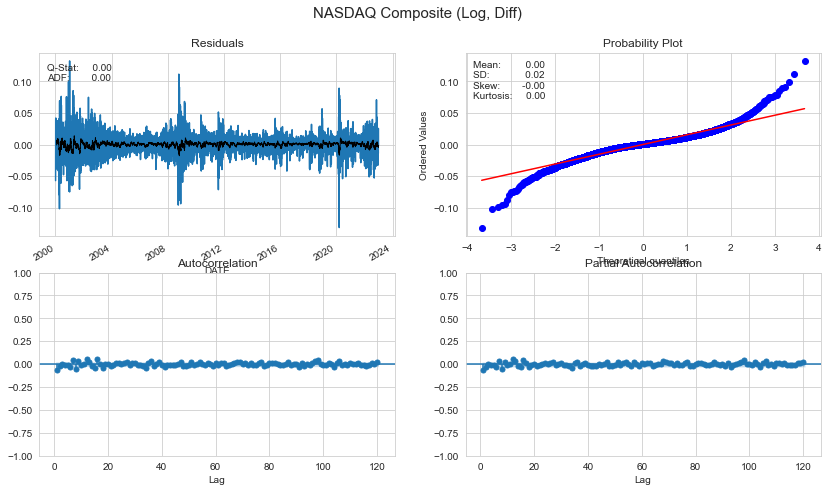

In [59]:
plot_correlogram(nasdaq_log_diff, lags=120, title='NASDAQ Composite (Log, Diff)')

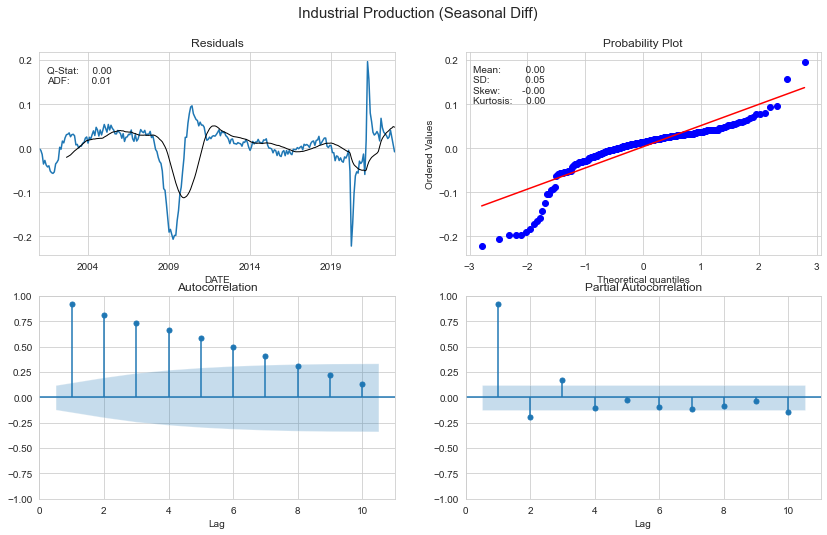

In [21]:
plot_correlogram(industrial_production_log_diff, title='Industrial Production (Seasonal Diff)')
# Q-Q plot(Quantile-Quantile Plot): Probability Plot